<a href="https://colab.research.google.com/github/carvalheiracarlos/deep_leaning_notebooks/blob/main/cifar_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

In [4]:
print(f'Train Sets Shapes.....X_train: {X_train.shape}')
print(f'Train Sets Shapes.....y_train: {y_train.shape}')
print(f'Tests Sets Shapes.....X_test: {X_test.shape}')
print(f'Tests Sets Shapes.....y_test: {y_test.shape}')

Train Sets Shapes.....X_train: (50000, 32, 32, 3)
Train Sets Shapes.....y_train: (50000, 1)
Tests Sets Shapes.....X_test: (10000, 32, 32, 3)
Tests Sets Shapes.....y_test: (10000, 1)


[6]


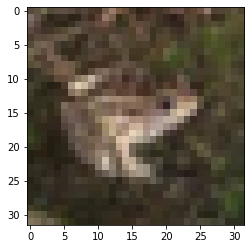

In [5]:
plt.imshow(X_train[22])
print(y_train[22])

In [6]:
# Scale images to the [0, 1] range
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255



y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)


In [6]:
validation_images, validation_labels = X_train[:5000], y_train[:5000]
train_images, train_labels = X_train[5000:], y_train[5000:]

In [7]:
# Referencies https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98

In [8]:
def process_images(image, label):
    image = tf.image.per_image_standardization(image)
    image = tf.image.resize(image, (32,32))
    return image, label

In [9]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))
train_images.shape

(45000, 32, 32, 3)

In [10]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()
print("Training data size:", train_ds_size)
print("Test data size:", test_ds_size)
print("Validation data size:", validation_ds_size)

Training data size: 45000
Test data size: 10000
Validation data size: 5000


In [11]:
train_ds = (train_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=10, drop_remainder=True))
test_ds = (test_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=10, drop_remainder=True))
validation_ds = (validation_ds
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size)
                  .batch(batch_size=10, drop_remainder=True))

In [10]:
class LightAlexNet:
  @staticmethod
  def build(n_channels, 
            rows, 
            cols, 
            n_classes, 
            activation='relu', 
            weights_path=None):
    model = keras.models.Sequential()
    
    input_Shape = (rows, cols, n_channels)
    
    model.add(keras.layers.Conv2D(filters=96, 
                                  kernel_size=(5,5),
                                  strides=(2,2),
                                  activation=activation, 
                                  input_shape=input_Shape))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    
    
    model.add(keras.layers.Conv2D(filters=256, 
                                  kernel_size=(5,5),
                                  strides=(1,1),
                                  activation=activation, 
                                  input_shape=input_Shape,
                                  padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    
    
    model.add(keras.layers.Conv2D(filters=384, 
                                  kernel_size=(3,3),
                                  strides=(1,1),
                                  activation=activation, 
                                  input_shape=input_Shape,
                                  padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    
    model.add(keras.layers.Conv2D(filters=384, 
                                  kernel_size=(3,3),
                                  strides=(1,1),
                                  activation=activation, 
                                  input_shape=input_Shape,
                                  padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    
    model.add(keras.layers.Conv2D(filters=384, 
                                  kernel_size=(3,3),
                                  strides=(1,1),
                                  activation=activation, 
                                  input_shape=input_Shape,
                                  padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(50, activation=activation))
    model.add(keras.layers.Dropout(0.5))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(50, activation=activation))
    model.add(keras.layers.Dropout(0.5))

    model.add(keras.layers.Dense(n_classes, activation='softmax'))

    # if a weights path is supplied (inicating that the model was
    # pre-trained), then load the weights
    if weights_path is not None:
      model.load_weights(weights_path)
    
    return model

In [8]:
n_epochs = 1
ini_learning_rate = 1e-3

In [14]:
with tf.device('/device:GPU:0') as sess:
    train_model = LightAlexNet.build(n_channels=3, 
                                     rows=32,
                                     cols=32, 
                                     n_classes=10, 
                                     activation='relu', 
                                     weights_path=None)

    opt = keras.optimizers.Adam(learning_rate=ini_learning_rate, decay=ini_learning_rate / n_epochs)
    train_model.compile(loss='categorical_crossentropy', 
                        optimizer=opt, 
                        metrics=[keras.metrics.categorical_accuracy])
    train_model.summary()
    try:
        file_path = 'weights/LightAlexNet.h5'
        check_point = keras.callbacks.ModelCheckpoint(file_path, 
                                                      monitor='accuracy', 
                                                      verbose=0, 
                                                      save_best_only=True,
                                                      mode='max',
                                                      save_weights_only=True)
        #add tensorboard callbacks
        tensorboard = keras.callbacks.TensorBoard('./logs/fit/')
        callbacks_list = [check_point, tensorboard]
        
        fit_history = train_model.fit(x=X_train,
                                      y=y_train,
                                      epochs=n_epochs,
                                      validation_split=0.1,
                                      validation_freq=1,
                                      callbacks=callbacks_list,
                                      verbose=1)
    
   
    except IOError:
        print('Error while saving the Model weights')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 14, 14, 96)        7296      
                                                                 
 batch_normalization_17 (Bat  (None, 14, 14, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 6, 6, 96)         0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 6, 6, 256)         614656    
                                                                 
 batch_normalization_18 (Bat  (None, 6, 6, 256)        1024      
 chNormalization)                                                
                                                      

1407/1407 [==============================] - 32s 10ms/step - loss: 2.3086 - categorical_accuracy: 0.0976 - val_loss: 2.3027 - val_categorical_accuracy: 0.0976
